# Definindo uma Arquitetura no PyTorch



**Carregando dados**

Exemplo de dados não-linearmente separáveis (distribuição em lua): <br>
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

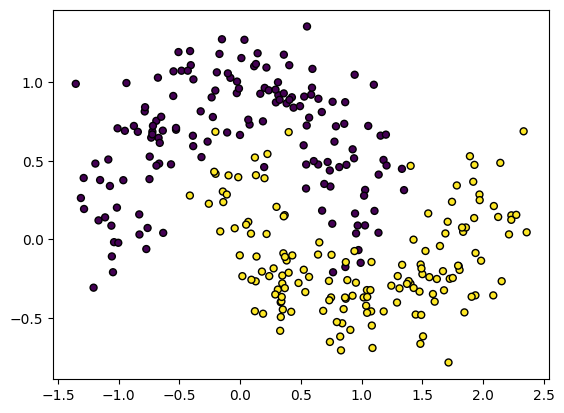

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X1, Y1 = make_moons(n_samples=300, noise=0.2)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', 
 c=Y1, s=25, edgecolor='k')

## nn.Sequential

O módulo ```nn.Sequential``` é um container onde se pode colocar múltiplos módulos. Ao realizar um ```forward``` em um objeto ```Sequential``` ele aplicará sequencialmente os módulos nele contidas para gerar uma saída.

Segue abaixo um exemplo desse módulo contendo 2 camadas ```Linear``` intercaladas por uma função de ativação ```ReLU```.

In [2]:
import torch
from torch import nn # neural networks
device = torch.device('cpu')

input_size = 2
hidden_size = 8
output_size = 1

net = nn.Sequential(nn.Linear(in_features=input_size, out_features=hidden_size), # hidden (escondida)
                    nn.ReLU(),   # ativação não linear
                    nn.Linear(in_features=hidden_size, out_features=output_size)) # output (saída)
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)


O módulo ```summary``` da biblioteca **```torchsummary```** nos permite visualizar mais informações sobre a nossa rede, como quantidade de parâmetros e o tamanho que cada elemento ocupa na memória.

Para mais informações, acesse: https://github.com/sksq96/pytorch-summary

In [3]:
from torchsummary import summary
summary(net.to(device), input_size=(1, input_size), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 8]              24
              ReLU-2                 [-1, 1, 8]               0
            Linear-3                 [-1, 1, 1]               9
Total params: 33
Trainable params: 33
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Forward

In [4]:
print(X1.shape)
tensor = torch.from_numpy(X1).float()
pred   = net(tensor)
print(pred.size())

(300, 2)
torch.Size([300, 1])


## Classe nn.Module

A forma mais organizada de definir modelos em PyTorch é implementando uma classe nos moldes da classe ```nn.Module```. Para redes pequenas, como as que estamos aprendendo até o momento, sua importância pode não se destacar, mas modelos maiores e com funcionalidades mais complexas, são mais fáceis de implementar e realizar manutenções dessa forma.

Funções obrigatórias do ```nn.Module```.
* ```__init()__```: definição de hiperparâmetros e instância do modelo 
* ```forward()```: Fluxo da entrada para produzir uma saída

In [5]:
class MinhaRede(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(MinhaRede, self).__init__()
    
    # Definir a arquitetura
    self.hidden = nn.Linear(input_size, hidden_size)
    self.relu   = nn.ReLU()
    self.output = nn.Linear(hidden_size, output_size)
    
  def forward(self, X):
    
    # Gerar uma saída a partir do X
    hidden = self.relu(self.hidden(X))
    output = self.output(hidden)
    
    return output

Instanciando a rede

In [6]:
input_size = 2
hidden_size = 8
output_size = 1

net = MinhaRede(input_size,hidden_size, output_size)  ## O método __init__()
print(net)

MinhaRede(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
)


### Forward

In [7]:
print(X1.shape)
tensor = torch.from_numpy(X1).float()
pred   = net(tensor)
print(pred.size())

(300, 2)
torch.Size([300, 1])


## Subindo informações na GPU

Para conseguir executar modelos maiores em tempo hábil, é preciso carregar as informação na GPU para que o processamento seja realizado por ela. Dentre as informações que conhecemos até o momento, duas delas precisam ser carregadas ba GPU:
* Entrada
* Rede

A célula a seguir contém a implementação sugerida para realizar esse processo. <br>
Se certifique que o notebook está na configuração desejada (CPU/GPU). Para isso, basta acessar ```Edit -> Notebook Settings``` e definir o hardware desejado.

In [8]:
# if torch.cuda.is_available():
#   device = torch.device('cuda')
# else:
#   device = torch.device('cpu')

device = torch.device('cpu')

print(device)

cpu


In [9]:
input_size = 2
hidden_size = 8
output_size = 1

net = MinhaRede(input_size,hidden_size, output_size)  ## O método __init__()
net = net.to(device)
print(net)

MinhaRede(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
)


In [10]:
print(X1.shape)
tensor = torch.from_numpy(X1).float()
tensor = tensor.to(device)
pred   = net(tensor)
print(pred.size())

(300, 2)
torch.Size([300, 1])
